<a href="https://colab.research.google.com/github/MpRonald/Machine-Learning/blob/main/Time_Series_DIY_Seasonal_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pandas.util.testing as tm
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib inline

# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings("ignore")

<ipython-input-1-c2741404e508>:2: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('https://github.com/MpRonald/datasets/raw/main/perrin-freres-monthly-champagne.csv')

In [3]:
data.columns = ['month', 'sales']
data.head()

,month,sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   106 non-null    object 
 1   sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [5]:
data.isnull().sum()

month    1
sales    2
dtype: int64

In [6]:
data = data.dropna()
data.isnull().sum()

month    0
sales    0
dtype: int64

In [7]:
data.duplicated().sum()

0

In [8]:
data.set_index('month', inplace=True)
data

,sales
month,
1964-01,2815.0
1964-02,2672.0
1964-03,2755.0
1964-04,2721.0
1964-05,2946.0
...,...
1972-05,4618.0
1972-06,5312.0
1972-07,4298.0


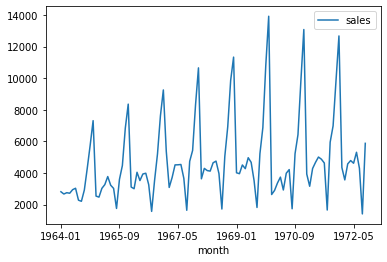

In [9]:
data.plot();

In [10]:
series_sales = data['sales']
series_sales

month
1964-01    2815.0
1964-02    2672.0
1964-03    2755.0
1964-04    2721.0
1964-05    2946.0
            ...  
1972-05    4618.0
1972-06    5312.0
1972-07    4298.0
1972-08    1413.0
1972-09    5877.0
Name: sales, Length: 105, dtype: float64

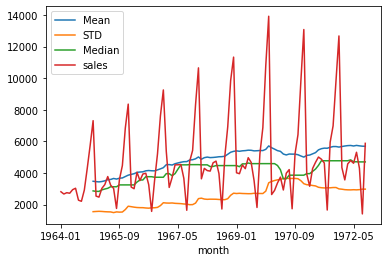

In [11]:
series_sales.rolling(12).mean().plot(label='Mean')
series_sales.rolling(12).std().plot(label='STD')
series_sales.rolling(12).median().plot(label='Median')
series_sales.plot()
plt.legend();

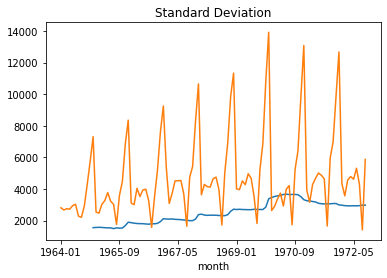

In [12]:
series_sales.rolling(12).std().plot()
plt.title('Standard Deviation')
series_sales.plot();

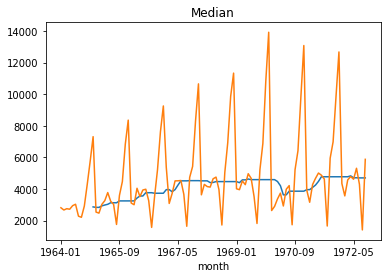

In [13]:
series_sales.rolling(12).median().plot()
plt.title('Median')
series_sales.plot();

# Time Series DIY: Seasonal Decomposition

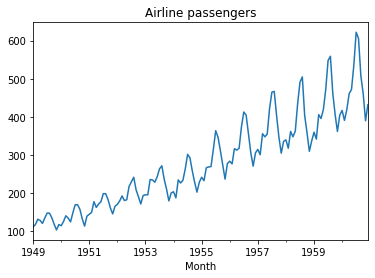

In [16]:
df = pd.read_csv("https://github.com/MpRonald/datasets/raw/main/AirPassengers.csv", index_col=0)
df.index = pd.to_datetime(df.index)
y = df["#Passengers"]
y.name = "n_passengers"

y.plot(title="Airline passengers");

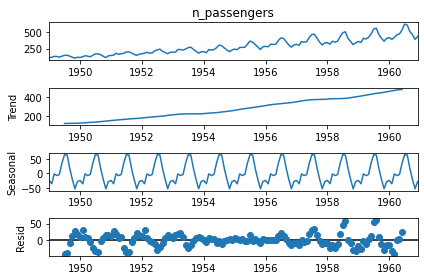

In [17]:
seasonal_decomp = seasonal_decompose(y, model="additive")
seasonal_decomp.plot();

In [18]:
# create the DF
seasonal_df = y.to_frame()

# calculate the trend component
seasonal_df["trend"] = seasonal_df["n_passengers"].rolling(window=13, center=True).mean()

# detrend the series
seasonal_df["detrended"] = seasonal_df["n_passengers"] - seasonal_df["trend"]

# calculate the seasonal component
seasonal_df.index = pd.to_datetime(seasonal_df.index)
seasonal_df["month"] = seasonal_df.index.month
seasonal_df["seasonality"] = seasonal_df.groupby("month")["detrended"].transform("mean")

# get the residuals
seasonal_df["resid"] = seasonal_df["detrended"] - seasonal_df["seasonality"]

# display the DF
seasonal_df.head(15)

,n_passengers,trend,detrended,month,seasonality,resid
Month,,,,,,
1949-01-01,112,NaN,NaN,1,-30.825175,NaN
1949-02-01,118,NaN,NaN,2,-42.027972,NaN
1949-03-01,132,NaN,NaN,3,-4.139860,NaN
1949-04-01,129,NaN,NaN,4,-6.944056,NaN
1949-05-01,121,NaN,NaN,5,-0.699301,NaN
1949-06-01,135,NaN,NaN,6,37.146853,NaN
1949-07-01,148,125.769231,22.230769,7,64.923077,-42.692308
1949-08-01,148,126.846154,21.153846,8,64.580420,-43.426573
1949-09-01,136,128.615385,7.384615,9,15.636364,-8.251748


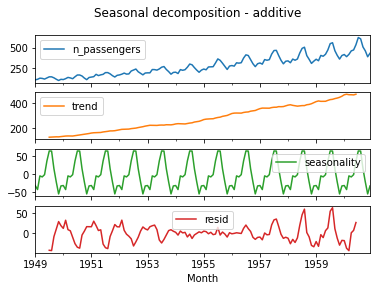

In [19]:
(seasonal_df.loc[:, ["n_passengers", "trend", "seasonality", "resid"]]\
    .plot(subplots=True, title="Seasonal decomposition - additive"));

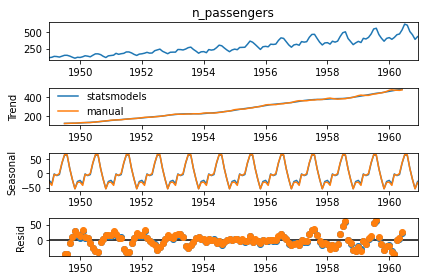

In [20]:
from statsmodels.tsa.seasonal import DecomposeResult 

manual_decomposition = DecomposeResult(
    seasonal=seasonal_df["seasonality"],
    trend=seasonal_df["trend"],
    resid=seasonal_df["resid"],
    observed=seasonal_df["n_passengers"],
)

def add_second_decomp_plot(fig, res, legend):
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

fig = seasonal_decomp.plot()
add_second_decomp_plot(fig, manual_decomposition, ["statsmodels", "manual"]);